# Asymptotic Vocabulary

<div class="alert alert-success"> 
Asymptotic behavior of the vocabulary set size necessary to describe an emoji vs number of users
==> How many users does it take to reach a stationary phase for a given emoji?
</div>

In [21]:
%load_ext autoreload
%autoreload 2
from src.data.form10_eda import read_form, str2vocab
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
form1_df = str2vocab(read_form("../data/raw/forms/emoji10/Emojis10_1.csv"))
form2_df = str2vocab(read_form("../data/raw/forms/emoji10/Emojis10_2.csv"))
form3_df = str2vocab(read_form("../data/raw/forms/emoji10/Emojis10_3.csv"))
form4_df = str2vocab(read_form("../data/raw/forms/emoji10/Emojis10_4.csv"))

In [81]:
def get_voc_size(serie):
    """
    return the vocabulary size of the words present in serie
    """
    return len(set([word for words_user in serie for word in words_user ]))

In [82]:
def build_trajectory(em_serie):
    """
    Return a random vocabulary size trajectory
    
    Args:
        em_serie (pd.Serie): serie of list of words for one emoji (independant users on each row assumed)
    
    Return:
        [dict]: dictionary mapping the size of voc to the number of users used to build this voc
    """
    em_serie = em_serie.sample(frac=1)

    # returned dictionary
    ret_dic = {}
    for n_user in range(1,em_serie.shape[0]+1):
        sub_serie = em_serie[:n_user]
        voc_size = get_voc_size(sub_serie)
        ret_dic[n_user] = voc_size
    return ret_dic    

In [100]:
def plot_trajectories(em_serie,ax=None,N_TRAJ = 20):
    """
    Generate and plot the random vocabulary size trajectories as described in build_trajectory
    
    Args:
        em_serie (pd.Serie): serie of list of words for one emoji (independant users on each row assumed) 
    """
    if ax is None:
        fig,ax = plt.subplots(1)
    trajectories = [pd.Series(build_trajectory(em_serie)) for i in range(N_TRAJ)]

    trajectories = pd.concat(trajectories,axis = 1)

    mean_traj = trajectories.mean(axis=1)
    median_traj = trajectories.median(axis=1)

    for col in trajectories.columns:
        trajectories[col].plot(ax=ax,color='red',alpha=0.5)
    mean_traj.plot(ax=ax,color='blue')
    median_traj.plot(ax=ax,color='red')
    # labels
    ax.set_xlabel('# of users')
    ax.set_ylabel('size of vocabulary')

In [106]:
def plot_multi_trajectories(form_df):
    """
    Plot the random trajectories as in plot_trajectories for the 9 first emojis of form_df
    """
    fig,axes = plt.subplots(3,3,figsize=(15,15))
    axes = axes.reshape(-1)
    for ax,col in zip(axes,form_df.columns):
        print(col,end="")
        plot_trajectories(form_df[col],ax)

😳😋😪🤠😚😷😟😃😨

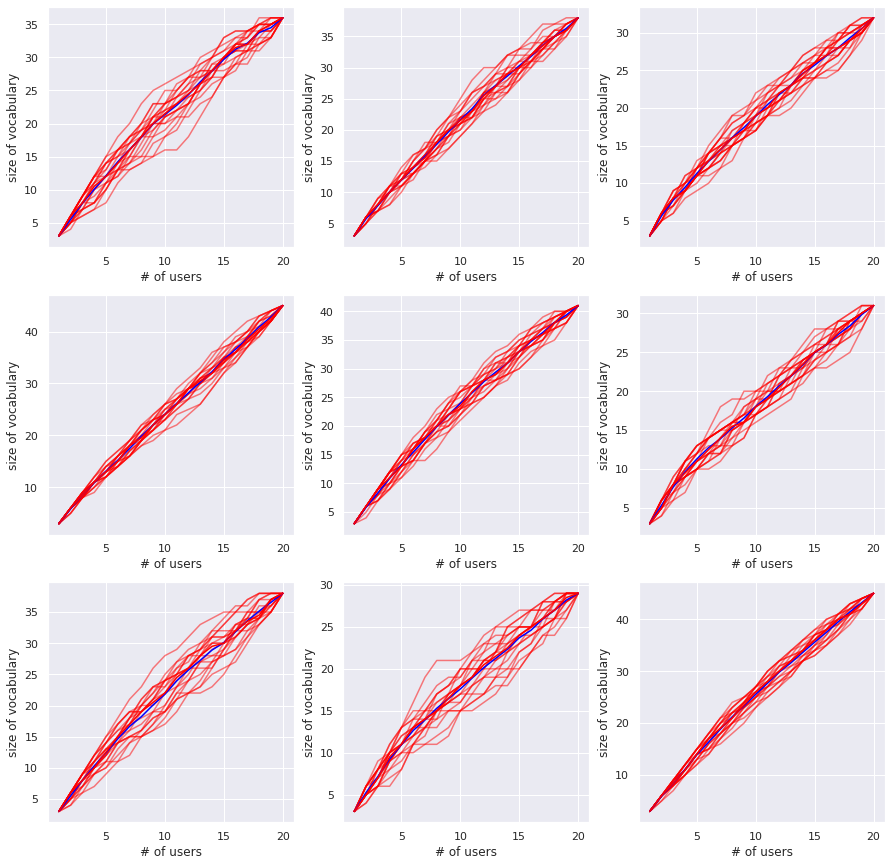

In [110]:
plot_multi_trajectories(form4_df)